# Feature Learning 特征学习

特征学习算法可以接收清洗后的数据，通过数据的潜在结构创建全新的特征。

特征学习和特征转换算法都创造了新的特征集，意思是我们认为这两类算法都属于特征提取。

![image.png](./img/特征提取.png)

重点关注：
- 受限玻尔兹曼机（RBM）：一种简单的深度学习架构，根据数据的概率模型学习一定数量的新特征。
- 词嵌入：词嵌入可以将字符串（单词或短语）投影到 n 维特征集中，以便理解上下文和措辞的细节。这里省略这部分内容，NLP 章节有详细介绍。
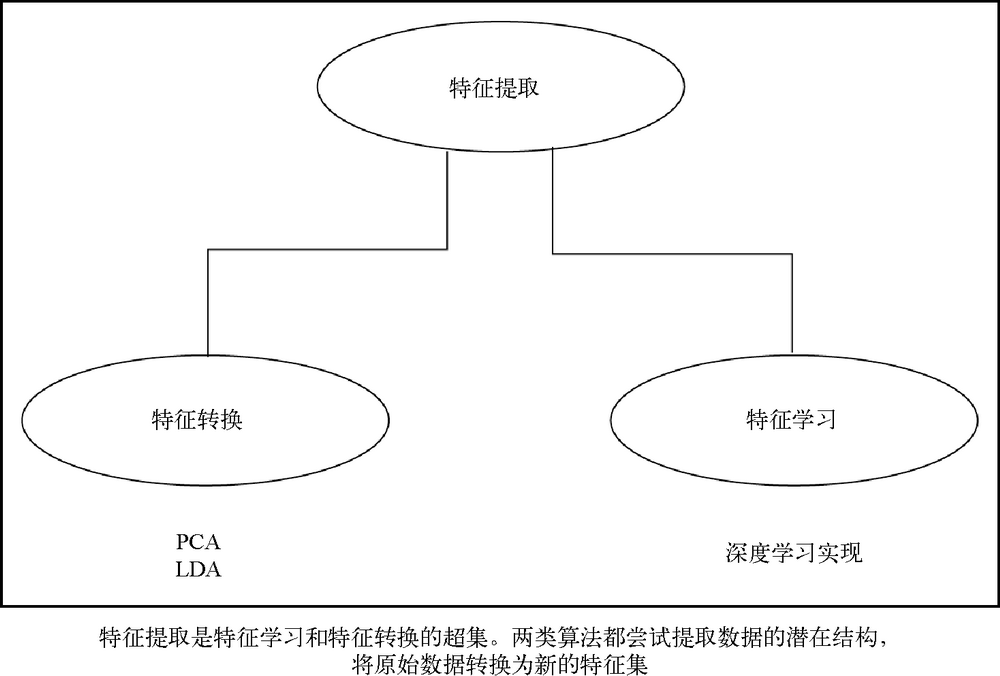

## 受限玻尔兹曼机 （RBM，Restricted Boltzmann Machine）

RBM 是一组**无监督**的特征学习算法，使用概率模型学习新特征。

与 PCA 和 LDA 一样，我们可以使用 RBM 从原始数据中提取新的特征集，用于增强机器学习流水线。

在 RBM 提取特征之后使用线性模型（线性回归、逻辑回归、感知机等）往往效果最佳。

RBM 是一个浅层（两层）的神经网络，属于深度信念网络（DBN，deep belief network）算法的一种。

RBM 有一个可见层（第一层），后面是一个隐藏层（第二层）。

![image.png](./img/rbm.png)

和 DNN 的区别是，RBM 不区分前向和反向，可见层的状态可以作用于隐藏层，而隐藏层的状态也可以作用于可见层。
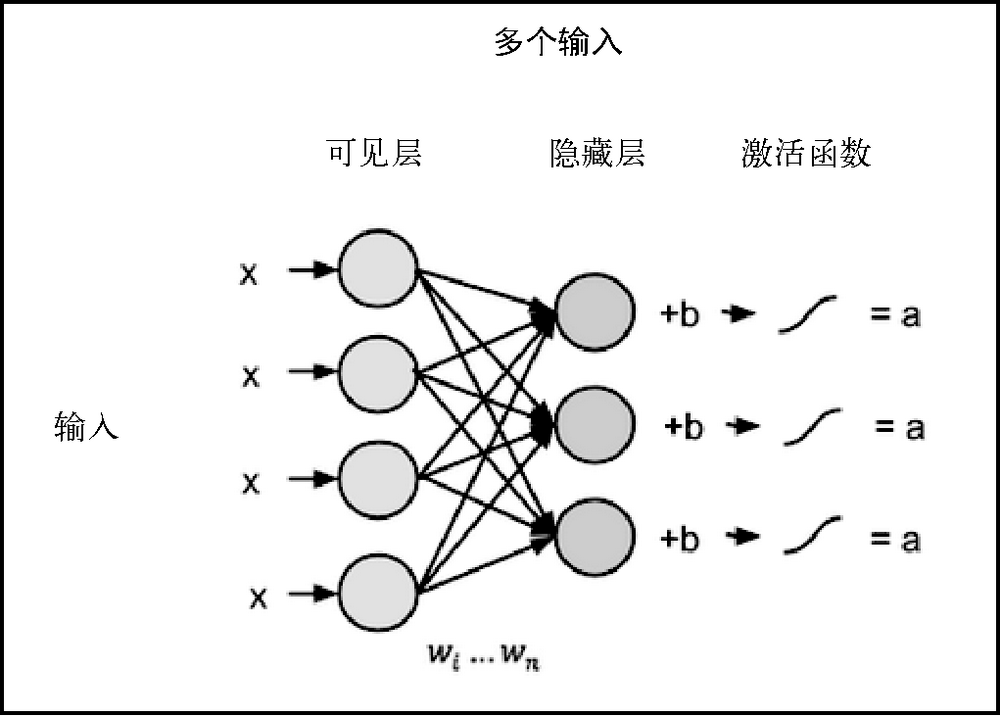

### MNIST数据集

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
images = np.genfromtxt('./data/mnist_train.csv', delimiter=',')
images.shape

(6000, 785)

In [3]:
# 提取 X 和 y 
images_X, images_y = images[:,1:], images[:,0]

5.0

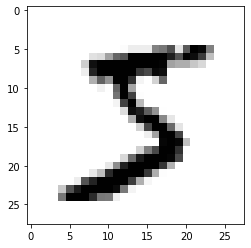

In [4]:
plt.imshow(images_X[0].reshape(28, 28), cmap=plt.cm.gray_r)

images_y[0]

### BernoulliRBM 伯努利受限玻尔兹曼机

scikit-learn 中唯一的RBM实现是 BernoulliRBM，因为它对原始数据的范围进行了约束。

In [5]:
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

In [6]:
# 把 images_X 缩放到 0~1
images_X = images_X / 255.

# 二分像素（白或黑）
images_X = (images_X > 0.5).astype(float)

np.min(images_X), np.max(images_X)

(0.0, 1.0)

5.0

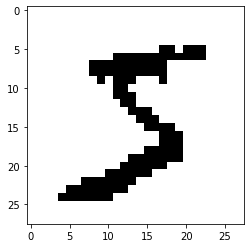

In [7]:
plt.imshow(images_X[0].reshape(28, 28), cmap=plt.cm.gray_r)

images_y[0]

可以看见，图像中的模糊消失了，要分类的数字很清晰。现在我们开始从数字数据集中提取特征。

### 从 MNIST 中提取 PCA 主成分

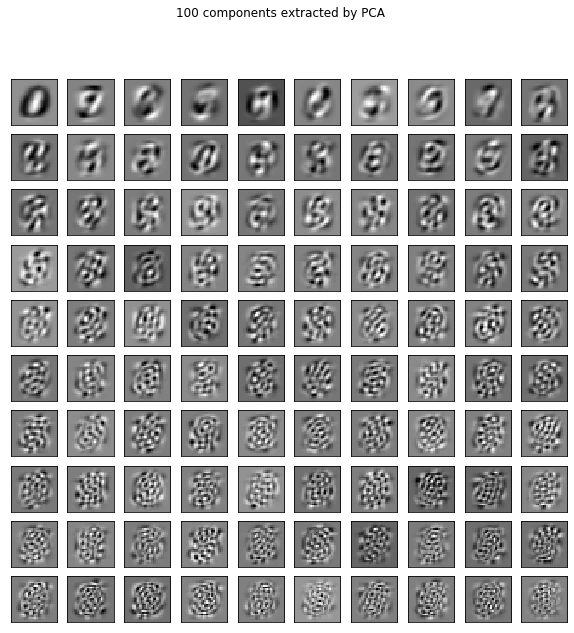

In [8]:
# 导入PCA模块
from sklearn.decomposition import PCA

# 100个特征数字
pca = PCA(n_components=100)
pca.fit(images_X)

# 绘制 100 个主成分
plt.figure(figsize=(10, 10))
for i, comp in enumerate(pca.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r)
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by PCA')

plt.show()

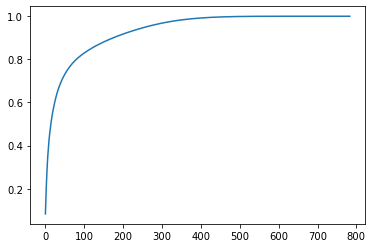

In [9]:
# 碎石图

# 所有的特征数字
full_pca = PCA(n_components=784)
full_pca.fit(images_X)

plt.plot(np.cumsum(full_pca.explained_variance_ratio_))

100 个主成分捕获约 90% 的方差

### 从 MNIST 中提取 RBM 特征

In [10]:
# 实例化 BernoulliRBM
# random_state: 初始化权重和偏差
# n_iter: 前后向传导次数
# n_components 与 PCA 和 LDA 一样，代表我们希望创建的特征数
# n_components 可以是任意整数，小于、等于或大于原始特征数均可

rbm = BernoulliRBM(random_state=0, verbose=True, n_iter=20, n_components=100)
rbm.fit(images_X)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -138.59, time = 1.38s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -120.25, time = 1.65s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -116.46, time = 1.41s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -117.78, time = 1.37s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -111.58, time = 1.39s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -112.17, time = 1.37s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -111.72, time = 1.35s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -115.78, time = 1.37s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -117.73, time = 1.46s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -114.76, time = 1.42s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -108.56, time = 1.39s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -114.70, time = 1.46s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -119.02, time = 1.60s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -110.22, time = 1.36s
[BernoulliRBM] 

BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=100, n_iter=20,
             random_state=0, verbose=True)

In [11]:
len(rbm.components_)

100

对RBM特征进行可视化，查看它和特征数字的区别：

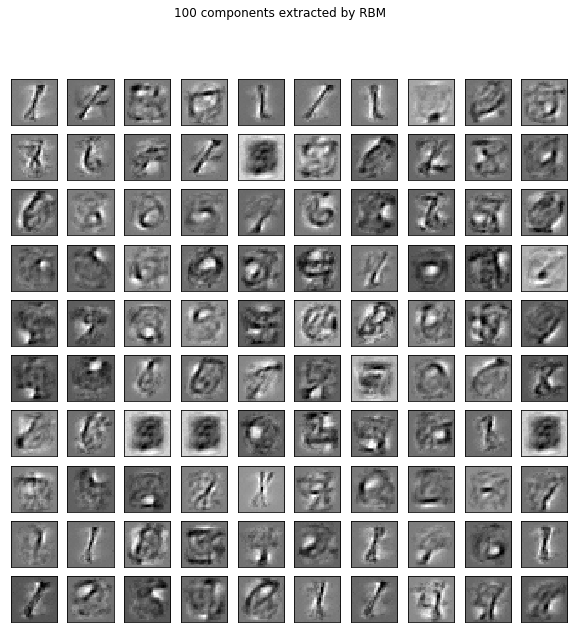

In [12]:
# 绘制RBM特征（新特征集的表示）
plt.figure(figsize=(10, 10))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r)
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM')

plt.show()

下面的代码会检查 rbm.components_ 的独立值数量。如果结果是 100，就代表 RBM 的每个特征其实都不同：

In [13]:
np.unique(rbm.components_.mean(axis=1)).shape

(100,)

好像有些特征一样，但是其实所有的特征都不一样（虽然有的很类似）。

### 在机器学习流水线中应用 RBM

流水线：
- 原始像素强度上的逻辑回归模型；
- PCA 主成分上的逻辑回归；
- RBM 特征上的逻辑回归。

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# 导入数据集
images = np.genfromtxt('./data/mnist_train.csv', delimiter=',')

# 划分数据
images_x, images_y = images[:,1:], images[:,0]

# 缩放特征到 0-1
images_x = images_x/255.

# 用 RBM 学习新特征
rbm = BernoulliRBM(random_state=0)
lr = LogisticRegression(solver='liblinear', multi_class='auto')

# 设置流水线的参数范围
params = {
    'clf__C':[1e-1, 1e0, 1e1],
    'rbm__n_components':[100, 200]
}

# 创建流水线
pipeline = Pipeline([('rbm', rbm),
                     ('clf', lr)])

# 实例化网格搜索类
grid = GridSearchCV(pipeline, params, cv=5)

# 拟合数据
grid.fit(images_x, images_y)

# 返回最佳参数
grid.best_params_, grid.best_score_

KeyboardInterrupt: 